# 4. 몬테카를로 제어 (On-policy Monte Carlo Control)

이번 챕터에서는 에이전트가 환경에 대한 모델(전이 확률 등)을 모르는 상태에서, 직접 상호작용하며 얻은 **경험(Experience)**을 바탕으로 정책을 학습하는 몬테카를로(MC) 제어 기법을 실습한다.

몬테카를로 방법은 에피소드가 끝날 때까지 기다렸다가, 얻어진 보상의 합(반환값, Return)을 이용해 가치 함수 $Q(s, a)$를 업데이트한다. 우리는 탐험(Exploration)을 유지하기 위해 -탐욕적(Epsilon-Greedy) 정책을 사용하는 On-policy 방식을 구현할 것이다.

### 0. 라이브러리 및 환경 설정

필요한 라이브러리를 불러오고, 실습에 사용할 미로(Maze) 환경과 시각화 도구를 정의한다. **Gymnasium** 라이브러리에 맞춰 커스텀 환경을 구성했다.

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from gymnasium import spaces
from IPython import display

# Jupyter Notebook 내 시각화 설정
%matplotlib inline

In [2]:
# ---------------------------------------------------------
# 1. 커스텀 Maze 환경 정의 (Gymnasium 기반)
# ---------------------------------------------------------
class Maze(gym.Env):
    def __init__(self):
        super().__init__()
        # 5x5 그리드, 상태는 (row, col) 좌표로 표현 (MultiDiscrete)
        self.observation_space = spaces.MultiDiscrete([5, 5])
        # 행동: 0:Up, 1:Right, 2:Down, 3:Left
        self.action_space = spaces.Discrete(4)
        self.state = np.array([0, 0])
        self.target = np.array([4, 4])
        self.render_mode = 'rgb_array'

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = np.array([0, 0])
        return self.state, {}

    def step(self, action):
        # 상, 우, 하, 좌 이동
        moves = {0: (-1, 0), 1: (0, 1), 2: (1, 0), 3: (0, -1)}
        move = moves[action]

        # 이동 후 좌표 (맵 밖으로 나가지 않도록 clip)
        next_state = self.state + np.array(move)
        next_state = np.clip(next_state, 0, 4)
        self.state = next_state

        # 종료 조건 및 보상
        terminated = np.array_equal(self.state, self.target)
        reward = -1.0 # 매 스텝 비용 발생
        if terminated:
            reward = 0.0 # 목표 도달 시 추가 비용 없음

        return self.state, reward, terminated, False, {}

    def render(self):
        # 5x5 그리드 이미지 생성
        grid = np.zeros((5, 5, 3), dtype=np.uint8) + 255
        grid[self.state[0], self.state[1]] = [0, 0, 255] # 파란색: 에이전트
        grid[self.target[0], self.target[1]] = [0, 255, 0] # 녹색: 목표
        return np.kron(grid, np.ones((40, 40, 1), dtype=np.uint8))

# ---------------------------------------------------------
# 2. 시각화 및 테스트를 위한 헬퍼 함수 정의
# ---------------------------------------------------------
def plot_action_values(action_values):
    # 각 상태에서 가장 높은 Q값(가치)을 히트맵으로 표시
    values = np.max(action_values, axis=2)
    plt.figure(figsize=(6, 6))
    plt.imshow(values, cmap='coolwarm', interpolation='none')
    for r in range(5):
        for c in range(5):
            plt.text(c, r, f"{values[r, c]:.1f}", ha='center', va='center', color='black')
    plt.colorbar(label='Max Q-value')
    plt.title("Action Value Table (Max Q)")
    plt.show()

def plot_policy(action_values):
    # 각 상태에서 가장 Q값이 높은 행동을 화살표로 표시
    best_actions = np.argmax(action_values, axis=2)
    plt.figure(figsize=(6, 6))
    plt.imshow(np.zeros((5, 5)), cmap='gray', vmin=0, vmax=1) # 배경

    arrows = {0: (0, -0.3), 1: (0.3, 0), 2: (0, 0.3), 3: (-0.3, 0)} # dx, dy
    for r in range(5):
        for c in range(5):
            if r == 4 and c == 4: continue # 목표 지점 제외
            action = best_actions[r, c]
            dx, dy = arrows[action]
            plt.arrow(c, r, dx, dy, head_width=0.1, head_length=0.1, fc='red', ec='red')
    plt.grid(color='white')
    plt.title("Optimal Policy (Greedy)")
    plt.show()

def test_agent(env, policy_fn, action_values):
    state, _ = env.reset()
    done = False
    step = 0
    img = plt.imshow(env.render())
    plt.axis('off')
    plt.title("Test Run")

    while not done and step < 20:
        # 테스트 시에는 탐험 없이 가장 좋은 행동(Greedy) 선택
        action = policy_fn(tuple(state), epsilon=0.0)
        state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        img.set_data(env.render())
        display.display(plt.gcf())
        display.clear_output(wait=True)
        step += 1
    print("테스트 종료")

---

## 1. 환경 초기화

우리가 정의한 `Maze` 환경을 생성한다. 상태 공간은 `(row, col)` 형태의 5x5 좌표이며, 행동 공간은 4가지 방향이다.

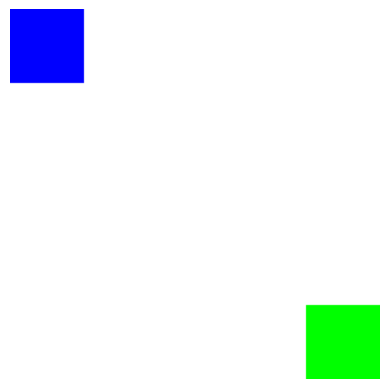

관찰 공간(Observation space): MultiDiscrete([5 5])
행동 공간(Action space) 크기: 4


In [3]:
env = Maze()

# 초기 상태 확인
initial_state, _ = env.reset()
frame = env.render()
plt.axis('off')
plt.imshow(frame)
plt.show()

print(f"관찰 공간(Observation space): {env.observation_space}")
print(f"행동 공간(Action space) 크기: {env.action_space.n}")

---

## 2. 행동 가치 함수  정의

에이전트가 학습할 **행동 가치 테이블(Q-Table)**을 초기화한다.
$Q(s, a)$는 상태 에서 행동 를 취했을 때 기대되는 반환값을 의미한다. 여기서는 5x5 그리드와 4가지 행동을 고려하여 `(5, 5, 4)` 크기의 배열을 만든다.

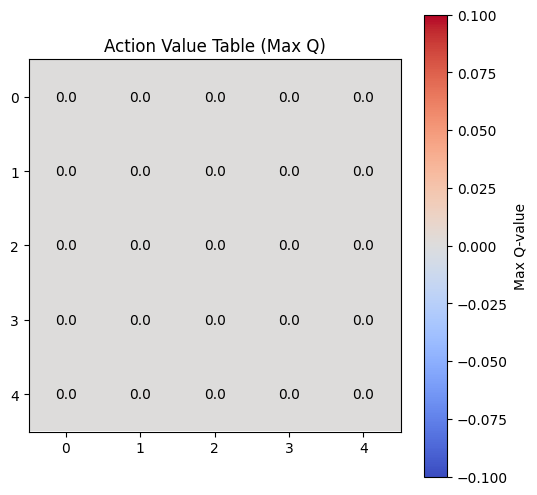

In [4]:
# 5x5 상태, 4개 행동에 대한 Q값 테이블. 0으로 초기화한다.
action_values = np.zeros(shape=(5, 5, 4))

# 초기 Q 테이블 시각화
plot_action_values(action_values)

---

## 3. 정책  정의

몬테카를로 제어에서는 **-탐욕적(Epsilon-Greedy)** 정책을 사용하여 탐험(Exploration)과 활용(Exploitation)의 균형을 맞춘다.

* 확률 으로 무작위 행동을 선택한다 (탐험).
* 확률 으로 현재 값이 가장 높은 행동을 선택한다 (활용).

In [5]:
def policy(state, epsilon=0.2):
    # state는 (row, col) 튜플이어야 함
    if np.random.random() < epsilon:
        # 무작위 행동 선택 (탐험)
        return np.random.randint(4)
    else:
        # Q값이 가장 높은 행동 선택 (활용)
        # 동점일 경우 무작위로 선택하여 편향 방지
        av = action_values[state[0], state[1]]
        return np.random.choice(np.flatnonzero(av == av.max()))

# 예시: 초기 상태에서 정책 테스트
action = policy((0,0), epsilon=0.5)
print(f"상태 (0,0)에서 선택된 행동: {action}")

상태 (0,0)에서 선택된 행동: 1


---

## 4. 몬테카를로 제어 알고리즘 구현

이제 핵심 알고리즘을 구현한다. 에피소드를 생성하고, 해당 에피소드에서 얻은 경험을 바탕으로 값을 업데이트하는 과정을 반복한다.
업데이트 방식은 **평균 반환값**을 사용하는 방법을 적용한다. 즉, 각 상태-행동 쌍 $(s, a)$에 대해 방문할 때마다 얻은 반환값들의 평균으로 $Q(s, a)$를 추정한다.

In [6]:
def on_policy_mc_control(policy, action_values, episodes, gamma=0.99, epsilon=0.2):
    # (상태, 행동) 별로 얻은 반환값(Return)들을 저장할 딕셔너리
    sa_returns = {}

    for episode in range(1, episodes + 1):
        state, _ = env.reset()
        done = False
        transitions = []

        # 1. 에피소드 생성 (Generate an episode)
        # 끝날 때까지 행동을 수행하며 기록한다.
        while not done:
            action = policy(tuple(state), epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # (상태, 행동, 보상) 저장
            transitions.append((state, action, reward))
            state = next_state

        # 2. Q-함수 업데이트 (Update Q-table)
        G = 0
        # 에피소드의 뒤에서부터 역순으로 계산 (G_t = R_{t+1} + gamma * G_{t+1})
        for state_t, action_t, reward_t in reversed(transitions):
            G = reward_t + gamma * G

            # 상태-행동 쌍을 키로 사용 (리스트나 ndarray는 키가 될 수 없으므로 튜플로 변환)
            sa_pair = (tuple(state_t), action_t)

            if sa_pair not in sa_returns:
                sa_returns[sa_pair] = []

            # 반환값 리스트에 추가하고 평균 계산
            sa_returns[sa_pair].append(G)

            # Q(s, a) = Average(Returns(s, a))
            # 상태 좌표 unpacking
            r, c = state_t
            action_values[r, c, action_t] = np.mean(sa_returns[sa_pair])

    return action_values

print("알고리즘 구현 완료")

알고리즘 구현 완료


---

## 5. 학습 실행 및 결과 확인

10,000번의 에피소드 동안 에이전트를 학습시킨다. 학습이 진행됨에 따라 테이블은 점차 최적의 경로에 대한 정보를 담게 된다.

In [7]:
# 학습 실행
print("학습 시작...")
on_policy_mc_control(
    policy, 
    action_values, 
    episodes=10000, 
    epsilon=0.2
)
print("학습 완료!")

학습 시작...
학습 완료!


### 5.1 학습된 가치 함수  시각화

각 상태에서 최대 가치를 가지는 행동의 값을 시각화한다. 목표 지점에 가까울수록(우측 하단) 값이 크고(덜 부정적), 멀어질수록 값이 작아지는 경향을 볼 수 있다.

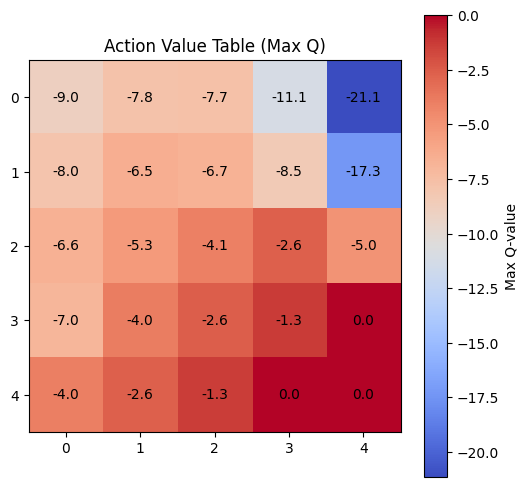

In [8]:
plot_action_values(action_values)

### 5.2 학습된 정책  시각화

각 상태에서 에이전트가 어떤 행동을 선택하는지(Greedy Policy) 화살표로 확인한다.

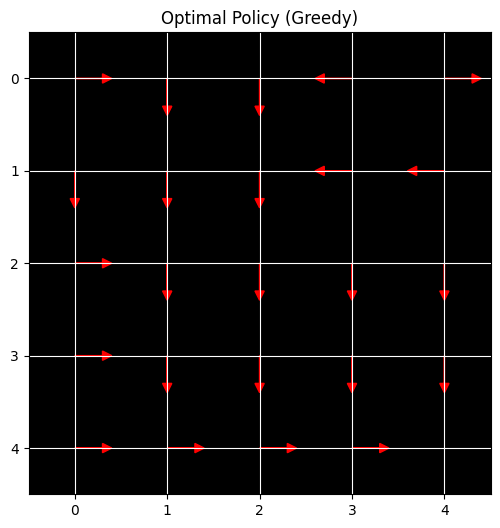

In [9]:
plot_policy(action_values)

### 5.3 에이전트 테스트

학습된 정책을 이용하여 에이전트가 실제로 미로를 잘 빠져나가는지 확인한다. 이때는 으로 설정하여 무작위 행동 없이 최적 행동만 하도록 한다.

테스트 종료


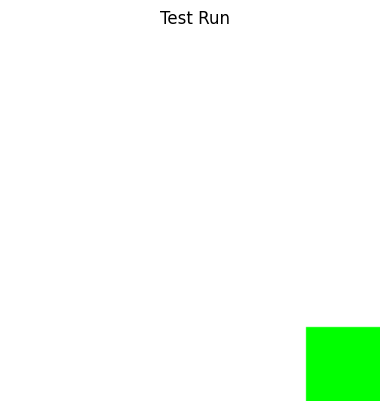

In [10]:
test_agent(env, policy, action_values)